# 使用 Featuretools 来自动化特征工程

- >**增加竞争者存在的时间月份长度**

- >**减小了 xgboost 模型学习率 eta**

-  这里不用 TPOT 找到的 gradientboost 而是直接采用 xgboost

- 通过之前的尝试，可以看到通过 TPOT 自动化生成的模型表现并不好，甚至不如基准模型
- 与最开始，手工构造特征工程后，使用的 Decision Tree 和 Adaboost 模型也有很大差距

- 手工构造特征工程的时候，主要是构造了 store average sales 等新的特征

- 因此，有理由相信，继续挖掘特征可以提高模型表现
- 但是，手动构造特征是一个非常耗时间的过程，同时，由于个人知识面、分析能力的差异，完全有可能漏掉很多需要复杂过程构造的特征
- 这里使用的是Featuretools,是一个开源 Python 库，项目地址https://docs.featuretools.com/#
- 学习参考的内容来源于https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219

In [41]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import xgboost as xgb
import os
from time import time
import operator
import matplotlib
import matplotlib.pyplot as plt

# Problem Description

- The task is a supervised regression problem: given sales data of Rossmann - a German chain drug store , I want to build a model that can predict the furture sales of Rossmann for the next 6 weeks. 

- Before I switch to the automated machine learning method, I have tried some complete machine learning model such as decision tree and Adaboost totally by hand. That is , the data cleaning, feature engineering, model selection and parameters tuning (although have not done yet for decision tree and adboost ) are done manualy

## Dataset

- Colab is able to retrieve data from GitHub directely

- store, train and test data sets are given but features and lables need to be splitted

- **Pay attention that test.csv does not include** ***Customers***

In [42]:
# read data from GitHub

train = pd.read_csv("inputs/train.csv")
test = pd.read_csv("inputs/test.csv")
store = pd.read_csv("inputs/store.csv")

print('Training data shape: ', train.shape)
print('testing data shape: ', test.shape)
print('Store data shape: ', store.shape)

Training data shape:  (1017209, 9)
testing data shape:  (41088, 8)
Store data shape:  (1115, 10)


/Users/limao/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## data cleaning

In [43]:
## 首先将 sales 取对数，否则计算rmspe-xg的时候要stack over flow
train['Sales'] = np.log1p(train['Sales'])

In [44]:
#train中去除open=1但是sales=0的数据

train = train.loc[train['Sales']>0]

print('{} train datas were deleted'.format(1017209 - len(train)))

172871 train datas were deleted


In [45]:
#train 中StateHoliday 将字符与数字0混淆，存在5个不同值

train.StateHoliday = train.StateHoliday.map({'0':'0',0:'0','a':'a','b':'b','c':'c'})

print('StateHoliday unique values {}'.format(len(train.StateHoliday.unique())))


StateHoliday unique values 4


In [46]:
#store中的NaN用0填充,表示没有竞争或者没有没有促销

store.fillna(0,inplace = True)

#test中的NaN用1填充,因为其中的NaN 全部是 Open，如果Open=0 则没有预测的必要了

test.fillna(1,inplace = True)

In [47]:
store.head()
store.isnull().any()

Store                        False
StoreType                    False
Assortment                   False
CompetitionDistance          False
CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2                       False
Promo2SinceWeek              False
Promo2SinceYear              False
PromoInterval                False
dtype: bool

In [48]:
train.head()
train.isnull().any()

Store            False
DayOfWeek        False
Date             False
Sales            False
Customers        False
Open             False
Promo            False
StateHoliday     False
SchoolHoliday    False
dtype: bool

In [49]:
test.head()
test.isnull().any()

Id               False
Store            False
DayOfWeek        False
Date             False
Open             False
Promo            False
StateHoliday     False
SchoolHoliday    False
dtype: bool

In [50]:
train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

## 使用 Featuretools 进行特征工程
特征工程中，构造新特征最主要的两项操作就是 transformation 和 aggregation. 前者是在单一 dataframe 上进行的操作，后者是在多个 dataframe 上进行的操作，非常类似于数据链表。其实，在 adaboost 模型中，构造单个store的平均值数据，已经用到了aggregation。但是，是通过手动的方式。featuretools 就是把一些列这些操作自动化，不仅可以节省很多时间，同时还可以挖掘出大量手动很难或者没有时间去构造的特征。正好这个项目中有 store、train 两个dataframe，因而很适合使用 featuretools.

## Entities and EntitySets

- 这两个是 featuretools 中的基本概念，简单讲其实一个 entity 就是一个dataframe。具体到本问题中，就是 test、store 

- entitysets 就是 entity 的集合。可以当做 Python 中另外一种数据类型

In [51]:
import featuretools as ft
# Create new entityset
es = ft.EntitySet(id = 'sales')

### 对于 store 有 unique index，那就是 ‘Store' ，因而可以用来构造 entity

In [52]:
# Create an entity from the store dataframe
# This dataframe already has an index 
es = es.entity_from_dataframe(entity_id = 'store', dataframe = store, 
                              variable_types = {'StoreType': ft.variable_types.Categorical,
                                                 'Assortment': ft.variable_types.Categorical,
                                                'Promo2': ft.variable_types.Categorical,
                                                'PromoInterval': ft.variable_types.Categorical},
                              index = 'Store')

In [53]:
es

Entityset: sales
  Entities:
    store [Rows: 1115, Columns: 10]
  Relationships:
    No relationships

### 对于 train dataframe，没有 unique index，所以必须添加 index

In [54]:
# Create an entity from the train dataframe
# This does not yet have a unique index
es = es.entity_from_dataframe(entity_id = 'train', 
                              dataframe = train,
                              variable_types = {'Promo': ft.variable_types.Categorical,
                                                 'StateHoliday': ft.variable_types.Categorical,
                                                 'SchoolHoliday': ft.variable_types.Categorical},
                              make_index = True,
                              index = 'train_id')

## Table relationship
简答说就是两张表中的“一对多”关系。具体在本项目中，store dataframe 是 train dataframe 的父表。因为，在store dataframe中一个store只有一行，而在train datafram 中一个记录了很多天的销售记录。父表与子表，通过共有的一个变量链接起来，在这里就 'Store'.

In [55]:
# Relationship between store and train
r_sales_previous = ft.Relationship(es['store']['Store'],
                                    es['train']['Store'])

In [56]:
# Add the relationship to the entity set
es = es.add_relationship(r_sales_previous)

In [57]:
es

Entityset: sales
  Entities:
    store [Rows: 1115, Columns: 10]
    train [Rows: 844338, Columns: 10]
  Relationships:
    train.Store -> store.Store

### 现在 entityset 就包含了 2个entity（dataframe）以及两张表之间的关系

## 现在就可以做 deep feature synthesis
- 其实就是合成新的特征，通过 aggregation 以及 transformation等方式。
- **最初的尝试中，没有设置agg/trans primitives**，然后导致最后的feature 有52个，太多了。

In [58]:
#ft.primitives.list_primitives()

In [59]:
# Perform deep feature synthesis without specifying primitives
features, feature_names = ft.dfs(entityset=es, target_entity='train', 
                                 agg_primitives = ['mean'],
                                 #trans_primitives = ['DayOfWeek'],
                                 max_depth = 2)

features.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,DAY(Date),YEAR(Date),...,store.Promo2SinceWeek,store.Promo2SinceYear,store.StoreType,store.Assortment,store.Promo2,store.PromoInterval,store.MEAN(train.DayOfWeek),store.MEAN(train.Sales),store.MEAN(train.Customers),store.MEAN(train.Open)
train_id,,,,,,,,,,,,,,,,,,,,,
0,1,5,8.568646,555,1,1,0,1,31,2015,...,0.0,0.0,c,a,0,0,3.504481,8.446708,564.049936,1
1,2,5,8.710290,625,1,1,0,1,31,2015,...,13.0,2010.0,a,a,1,"Jan,Apr,Jul,Oct",3.506378,8.453979,583.998724,1
2,3,5,9.025816,821,1,1,0,1,31,2015,...,14.0,2011.0,a,a,1,"Jan,Apr,Jul,Oct",3.499358,8.795941,750.077022,1
3,4,5,9.546527,1498,1,1,0,1,31,2015,...,0.0,0.0,c,c,0,0,3.506378,9.154714,1321.752551,1
4,5,5,8.481151,559,1,1,0,1,31,2015,...,0.0,0.0,a,a,0,0,3.508344,8.369616,537.340180,1


In [60]:
features['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [61]:
avgperday = features.groupby(['Store', 'DayOfWeek'])['Sales'].mean().reset_index()
avgperday.columns = ['Store','DayOfWeek','AvgPerDay']
avgperday.head()

,Store,DayOfWeek,AvgPerDay
0,1,1,8.525573
1,1,2,8.428742
2,1,3,8.404854
3,1,4,8.382763
4,1,5,8.444185


In [62]:
avgperday.describe()

,Store,DayOfWeek,AvgPerDay
count,6723.000000,6723.000000,6723.000000
mean,558.149189,3.517180,8.756828
std,321.771361,1.721228,0.357361
min,1.000000,1.000000,6.801461
25%,280.000000,2.000000,8.541215
50%,558.000000,4.000000,8.764460
75%,837.000000,5.000000,8.973210
max,1115.000000,7.000000,10.249988


In [63]:
features = pd.merge(features,avgperday,on =['Store','DayOfWeek'],how ='left')

In [64]:
list(features)

['Store',
 'DayOfWeek',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'DAY(Date)',
 'YEAR(Date)',
 'MONTH(Date)',
 'WEEKDAY(Date)',
 'store.CompetitionDistance',
 'store.CompetitionOpenSinceMonth',
 'store.CompetitionOpenSinceYear',
 'store.Promo2SinceWeek',
 'store.Promo2SinceYear',
 'store.StoreType',
 'store.Assortment',
 'store.Promo2',
 'store.PromoInterval',
 'store.MEAN(train.DayOfWeek)',
 'store.MEAN(train.Sales)',
 'store.MEAN(train.Customers)',
 'store.MEAN(train.Open)',
 'AvgPerDay']

## 在 store 中增加考虑竞争时长的 feature

### 单一商店竞争存在的月份时间长

In [65]:
#features['YEAR(Date)']-features['store.CompetitionOpenSinceYear']

In [66]:
features['CompetitionExistMonth'] = 12 * (features['YEAR(Date)']- features['store.CompetitionOpenSinceYear']) + (features['MONTH(Date)']-features['store.CompetitionOpenSinceMonth'])
    
#不存在竞争的，对应竞争存在月份当然置于0
features.loc[features['store.CompetitionOpenSinceYear'] == 0, 'CompetitionExistMonth'] =0

### 单一商店促销存在的月份长度

In [67]:
features['Promo2ExistMonth'] = 12 * (features['YEAR(Date)']-features['store.Promo2SinceYear']) +\
(features['MONTH(Date)']-features['store.Promo2SinceWeek']/4)
    
#不存在竞争的，对应竞争存在月份当然置于0
features.loc[features['store.Promo2SinceYear'] == 0, 'Promo2ExistMonth'] =0

In [68]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 28 columns):
Store                              844338 non-null int64
DayOfWeek                          844338 non-null int64
Sales                              844338 non-null float64
Customers                          844338 non-null int64
Open                               844338 non-null int64
Promo                              844338 non-null int64
StateHoliday                       844338 non-null object
SchoolHoliday                      844338 non-null int64
DAY(Date)                          844338 non-null int64
YEAR(Date)                         844338 non-null int64
MONTH(Date)                        844338 non-null int64
WEEKDAY(Date)                      844338 non-null int64
store.CompetitionDistance          844338 non-null float64
store.CompetitionOpenSinceMonth    844338 non-null float64
store.CompetitionOpenSinceYear     844338 non-null float64
store.Promo2SinceWeek    

## 剔除掉没意义的 feature
- DAY(Date)\YEAR(Date)\MONTH(Date)\WEEKDAY(Date)\Cusoterms ,因为test数据中没有date
- store.MEAN(train.DayOfWeek)\store.MEAN(train.Open),也没有意义，因为我们需要预测的肯定都是开着的商店。考察一周平均开几天没有意义

In [69]:
# features.drop({'Customers','DAY(Date)','YEAR(Date)','MONTH(Date)','WEEKDAY(Date)','store.MEAN(train.DayOfWeek)','store.MEAN(train.Open)'},
#               inplace = True, axis =1)

features.drop({'Customers','WEEKDAY(Date)','store.MEAN(train.DayOfWeek)','store.MEAN(train.Open)'},
               inplace = True, axis =1)

In [70]:
features.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,DAY(Date),YEAR(Date),MONTH(Date),...,store.Promo2SinceYear,store.StoreType,store.Assortment,store.Promo2,store.PromoInterval,store.MEAN(train.Sales),store.MEAN(train.Customers),AvgPerDay,CompetitionExistMonth,Promo2ExistMonth
0,1,5,8.568646,1,1,0,1,31,2015,7,...,0.0,c,a,0,0,8.446708,564.049936,8.444185,82.0,0.00
1,2,5,8.710290,1,1,0,1,31,2015,7,...,2010.0,a,a,1,"Jan,Apr,Jul,Oct",8.453979,583.998724,8.433972,92.0,63.75
2,3,5,9.025816,1,1,0,1,31,2015,7,...,2011.0,a,a,1,"Jan,Apr,Jul,Oct",8.795941,750.077022,8.860622,103.0,51.50
3,4,5,9.546527,1,1,0,1,31,2015,7,...,0.0,c,c,0,0,9.154714,1321.752551,9.140853,70.0,0.00
4,5,5,8.481151,1,1,0,1,31,2015,7,...,0.0,a,a,0,0,8.369616,537.340180,8.474541,3.0,0.00


In [71]:
# Sales 是预测值 label，需要从 features 中剔除

label = features['Sales'].to_frame()

features.drop('Sales',axis =1, inplace = True)

label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 1 columns):
Sales    844338 non-null float64
dtypes: float64(1)
memory usage: 12.9 MB


### one-hot encoding categorical features

- 非数值特征需要进行独热编码

In [72]:
features = pd.get_dummies(features,
                         prefix=['StateHoliday','store.StoreType', 'store.Assortment','store.PromoInterval'], 
                         drop_first=True)

#不知道为什么在这里get_dummy 把 StateHoliday = 0 忽略了，导致独热编码后只有3个种类，因而改成用map
#features.StateHoliday = train.StateHoliday.map({'0':0,'a':1,'b':2,'c':2})

In [73]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 30 columns):
Store                                   844338 non-null int64
DayOfWeek                               844338 non-null int64
Open                                    844338 non-null int64
Promo                                   844338 non-null int64
SchoolHoliday                           844338 non-null int64
DAY(Date)                               844338 non-null int64
YEAR(Date)                              844338 non-null int64
MONTH(Date)                             844338 non-null int64
store.CompetitionDistance               844338 non-null float64
store.CompetitionOpenSinceMonth         844338 non-null float64
store.CompetitionOpenSinceYear          844338 non-null float64
store.Promo2SinceWeek                   844338 non-null float64
store.Promo2SinceYear                   844338 non-null float64
store.Promo2                            844338 non-null int64
store.MEAN(

In [74]:
list(features)

['Store',
 'DayOfWeek',
 'Open',
 'Promo',
 'SchoolHoliday',
 'DAY(Date)',
 'YEAR(Date)',
 'MONTH(Date)',
 'store.CompetitionDistance',
 'store.CompetitionOpenSinceMonth',
 'store.CompetitionOpenSinceYear',
 'store.Promo2SinceWeek',
 'store.Promo2SinceYear',
 'store.Promo2',
 'store.MEAN(train.Sales)',
 'store.MEAN(train.Customers)',
 'AvgPerDay',
 'CompetitionExistMonth',
 'Promo2ExistMonth',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'store.StoreType_b',
 'store.StoreType_c',
 'store.StoreType_d',
 'store.Assortment_b',
 'store.Assortment_c',
 'store.PromoInterval_Feb,May,Aug,Nov',
 'store.PromoInterval_Jan,Apr,Jul,Oct',
 'store.PromoInterval_Mar,Jun,Sept,Dec']

## 用 Train 数据训练测试模型

In [75]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X = [
    'Store',
    'DayOfWeek',
    'Open',
    'Promo',
    'SchoolHoliday',
    'store.CompetitionDistance',
    'store.CompetitionOpenSinceMonth',
    'store.CompetitionOpenSinceYear',
    'store.Promo2SinceWeek',
    'store.Promo2SinceYear',
    'store.Promo2',
    'store.MEAN(train.Sales)',
    'store.MEAN(train.Customers)',
    'AvgPerDay',
    'StateHoliday_a',
    'StateHoliday_b',
    'StateHoliday_c',
    'store.StoreType_b',
    'store.StoreType_c',
    'store.StoreType_d',
    'store.Assortment_b',
    'store.Assortment_c',
    'store.PromoInterval_Feb,May,Aug,Nov',
    'store.PromoInterval_Jan,Apr,Jul,Oct',
    'store.PromoInterval_Mar,Jun,Sept,Dec'  
]




#X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.33, random_state=42)



### 提取出 hold out data

In [76]:
#最后6个星期
features_hold = features[6*7*1115:]
features_train = features[:6*7*1115]

label_hold = label[6*7*1115:]
label_train = label[:6*7*1115]

### 定义误差计算公式

In [77]:
def rmspe(y, yhat):
    return np.sqrt(np.mean(((y-yhat)/y) ** 2))

def rmspe_xg(yhat, y): 
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

### 定义 xgboost 参数

In [78]:
# 首先将数据转化为 Dmatrix 加快运算速度
dtrain = xgb.DMatrix(features_train, label_train)
dvalid = xgb.DMatrix(features_hold, label_hold)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

### 减小 xgboost 学习率 eta

In [79]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.003,
          "max_depth": 10,
          "min_child_weight": 6,
          "subsample": 0.9,
          "colsample_bytree": 0.6,
          "silent": 1,
          "seed": 1301
          }

num_boost_round = 8000
early_stopping_rounds = 100

In [80]:
# feval = rmspe_xg 引起错误？
print("start to train XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=early_stopping_rounds, feval = rmspe_xg,verbose_eval=100)
end = time()
print('Training time is {:2f} s.'.format(end-start))

start to train XGBoost model
[0]	train-rmse:8.27068	eval-rmse:8.24226	train-rmspe:0.999885	eval-rmspe:0.999881
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[100]	train-rmse:6.1264	eval-rmse:6.09966	train-rmspe:0.997829	eval-rmspe:0.997758
[200]	train-rmse:4.53865	eval-rmse:4.51341	train-rmspe:0.98895	eval-rmspe:0.988592
[300]	train-rmse:3.36297	eval-rmse:3.33921	train-rmspe:0.964285	eval-rmspe:0.963163
[400]	train-rmse:2.49269	eval-rmse:2.47051	train-rmspe:0.915193	eval-rmspe:0.912662
[500]	train-rmse:1.84872	eval-rmse:1.82842	train-rmspe:0.839222	eval-rmspe:0.834832
[600]	train-rmse:1.37243	eval-rmse:1.35445	train-rmspe:0.741976	eval-rmspe:0.735851
[700]	train-rmse:1.02036	eval-rmse:1.00497	train-rmspe:0.634058	eval-rmspe:0.627216
[800]	train-rmse:0.760459	eval-rmse:0.748707	train-rmspe:0.526457	eval-rmspe:0.521092
[900]	train-rmse:0.568986	eval-rmse:0.561886	train-rmspe:0.427558	eval-

### 增加early_stopping_rounds/num_boost_round

In [137]:
params1 = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.01,
          "max_depth": 10,
          "min_child_weight": 6,
          "subsample": 0.9,
          "colsample_bytree": 0.6,
          "silent": 1,
          "seed": 1301,
          "num_boost_round":15000,
          "early_stopping_rounds":600  
          }



In [140]:
print("start to train new XGBoost model")
start = time()
gbm1 = xgb.train(params1, dtrain,num_boost_round=15000,evals=watchlist,early_stopping_rounds=600,feval = rmspe_xg,verbose_eval=100)
end = time()
print('Training time is {:2f} s.'.format(end-start))

start to train new XGBoost model
[0]	train-rmse:8.21265	eval-rmse:8.18429	train-rmspe:0.999868	eval-rmspe:0.999864
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 600 rounds.
[100]	train-rmse:3.01147	eval-rmse:2.98832	train-rmspe:0.949342	eval-rmspe:0.947788
[200]	train-rmse:1.1106	eval-rmse:1.09406	train-rmspe:0.665356	eval-rmspe:0.658535
[300]	train-rmse:0.42138	eval-rmse:0.421256	train-rmspe:0.337622	eval-rmspe:0.34723
[400]	train-rmse:0.180617	eval-rmse:0.217448	train-rmspe:0.161555	eval-rmspe:0.236197
[500]	train-rmse:0.107181	eval-rmse:0.181103	train-rmspe:0.10243	eval-rmspe:0.235053
[600]	train-rmse:0.087559	eval-rmse:0.179538	train-rmspe:0.087594	eval-rmspe:0.245383
[700]	train-rmse:0.08112	eval-rmse:0.181188	train-rmspe:0.082805	eval-rmspe:0.251295
[800]	train-rmse:0.077488	eval-rmse:0.182394	train-rmspe:0.079628	eval-rmspe:0.254326
[900]	train-rmse:0.074831	eval-rmse:0.183136	train-rmspe:0.0

In [141]:
params2 = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.01,
          "max_depth": 10,
          "min_child_weight": 6,
          "subsample": 1,
          "colsample_bytree": 0.8,
          "silent": 1,
          "seed": 1301
          }

In [142]:
print("start to train new XGBoost model")
start = time()
gbm2 = xgb.train(params2, dtrain,num_boost_round=800,evals=watchlist,early_stopping_rounds=100,feval = rmspe_xg,verbose_eval=100)
end = time()
print('Training time is {:2f} s.'.format(end-start))

start to train new XGBoost model
[0]	train-rmse:8.21266	eval-rmse:8.18418	train-rmspe:0.999868	eval-rmspe:0.999864
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[100]	train-rmse:3.01066	eval-rmse:2.98824	train-rmspe:0.949459	eval-rmspe:0.94797
[200]	train-rmse:1.10953	eval-rmse:1.09406	train-rmspe:0.665559	eval-rmspe:0.659245
[300]	train-rmse:0.420089	eval-rmse:0.419403	train-rmspe:0.337226	eval-rmspe:0.346826
[400]	train-rmse:0.179055	eval-rmse:0.214885	train-rmspe:0.160454	eval-rmspe:0.235275
[500]	train-rmse:0.105266	eval-rmse:0.178979	train-rmspe:0.100692	eval-rmspe:0.234667
Stopping. Best iteration:
[440]	train-rmse:0.138005	eval-rmse:0.190963	train-rmspe:0.127081	eval-rmspe:0.230114

Training time is 150.353733 s.


In [143]:
params3 = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.005,
          "max_depth": 10,
          "min_child_weight": 6,
          "subsample": 1,
          "colsample_bytree": 0.8,
          "silent": 1,
          "seed": 1301
          }

In [144]:
print("start to train new XGBoost model")
start = time()
gbm3 = xgb.train(params3, dtrain,num_boost_round=18000,evals=watchlist,early_stopping_rounds=100,feval = rmspe_xg,verbose_eval=100)
end = time()
print('Training time is {:2f} s.'.format(end-start))

start to train new XGBoost model
[0]	train-rmse:8.25411	eval-rmse:8.22564	train-rmspe:0.99988	eval-rmspe:0.999876
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[100]	train-rmse:5.0027	eval-rmse:4.97761	train-rmspe:0.993104	eval-rmspe:0.992886
[200]	train-rmse:3.03343	eval-rmse:3.01102	train-rmspe:0.950595	eval-rmspe:0.949141
[300]	train-rmse:1.84138	eval-rmse:1.82243	train-rmspe:0.838405	eval-rmspe:0.834342
[400]	train-rmse:1.12066	eval-rmse:1.10541	train-rmspe:0.669218	eval-rmspe:0.663042
[500]	train-rmse:0.685942	eval-rmse:0.675915	train-rmspe:0.490659	eval-rmspe:0.486944
[600]	train-rmse:0.425081	eval-rmse:0.424305	train-rmspe:0.340482	eval-rmspe:0.349665
[700]	train-rmse:0.270369	eval-rmse:0.284927	train-rmspe:0.231869	eval-rmspe:0.268356
[800]	train-rmse:0.181067	eval-rmse:0.216166	train-rmspe:0.162089	eval-rmspe:0.235735
[900]	train-rmse:0.131943	eval-rmse:0.188074	train-rmspe:0.12

In [38]:
#model = GradientBoostingRegressor(verbose=True)

In [39]:
# model.fit(X_train, y_train)
# model.score(X_test, y_test)

## 用 hold out data 做 correction


### 计算误差残值 residual

- 这一步计算量非常大，只能在GCP中运行

In [81]:
features_hold.sort_index(inplace=True) 
label_hold.sort_index(inplace=True) 

yhat = gbm.predict(xgb.DMatrix(features_hold))

# error = rmspe(np.expm1(label_hold.values), np.expm1(yhat))
# print('RMSPE: {:.6f}'.format(error))

In [82]:
# 构造residual dataframe
res = pd.DataFrame(data = label_hold)
res['Prediction']=yhat
res = pd.merge(features_hold,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,DAY(Date),YEAR(Date),MONTH(Date),store.CompetitionDistance,store.CompetitionOpenSinceMonth,...,store.Assortment_b,store.Assortment_c,"store.PromoInterval_Feb,May,Aug,Nov","store.PromoInterval_Jan,Apr,Jul,Oct","store.PromoInterval_Mar,Jun,Sept,Dec",Sales,Prediction,Ratio,Error,Weight
46830,948,6,1,0,0,13,2015,6,1430.0,0.0,...,1,0,0,0,0,8.765459,8.676054,0.989800,0.010200,1.010305
46831,949,6,1,0,0,13,2015,6,870.0,3.0,...,0,0,0,0,0,8.018955,7.965338,0.993314,0.006686,1.006731
46832,950,6,1,0,0,13,2015,6,8460.0,11.0,...,0,0,0,0,0,8.354204,8.206239,0.982289,0.017711,1.018031
46833,951,6,1,0,0,13,2015,6,710.0,0.0,...,0,1,0,1,0,8.957768,8.825646,0.985251,0.014749,1.014970
46834,952,6,1,0,0,13,2015,6,6300.0,10.0,...,0,1,0,0,0,8.692826,8.734648,1.004811,0.004811,0.995212


### 画出随机三个商店预测值与实际值对比

Mean Ratio of predition and real sales data is 0.9950202616243704: store all
Mean Ratio of predition and real sales data is 1.0052341517951304: store 589
Mean Ratio of predition and real sales data is 0.9932085341291014: store 811
Mean Ratio of predition and real sales data is 0.991892332338225: store 479


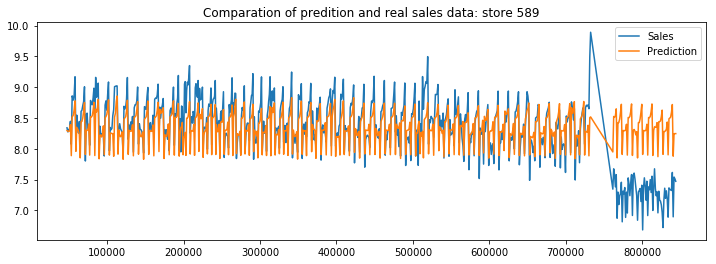

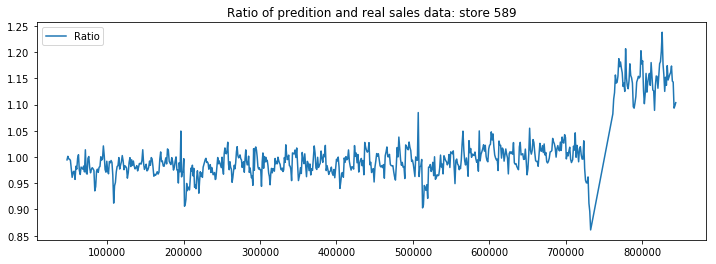

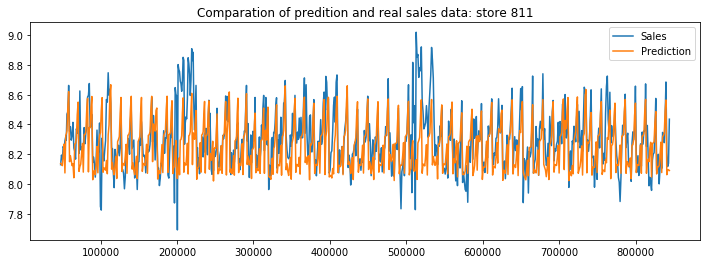

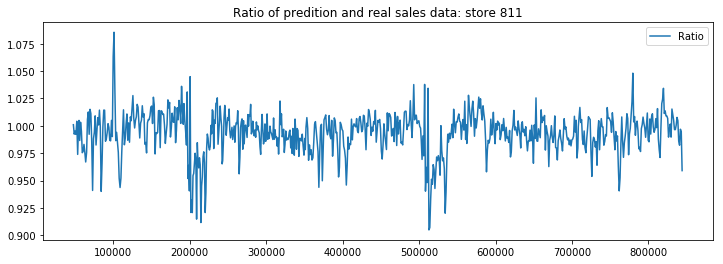

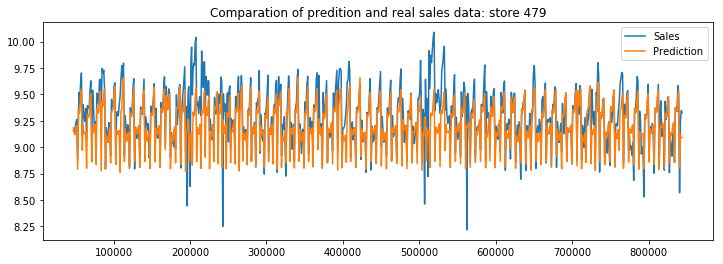

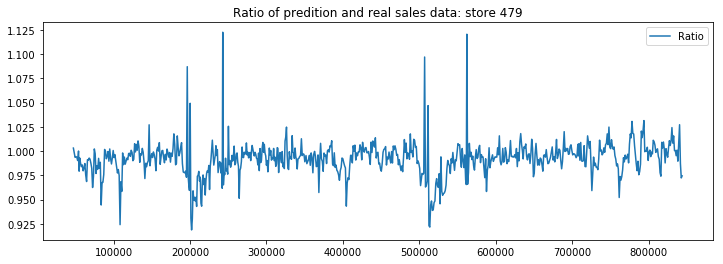

In [83]:
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']
L=np.random.randint( low=1,high = 1115, size = 3 ) 
print('Mean Ratio of predition and real sales data is {}: store all'.format(res.Ratio.mean()))
for i in L:
    
    s1 = pd.DataFrame(res[res['Store']==i],columns = col_1)
    s2 = pd.DataFrame(res[res['Store']==i],columns = col_2)
    s1.plot(title = 'Comparation of predition and real sales data: store {}'.format(i),figsize=(12,4))
    s2.plot(title = 'Ratio of predition and real sales data: store {}'.format(i),figsize=(12,4))
    print('Mean Ratio of predition and real sales data is {}: store {}'.format(s2.Ratio.mean(),i))

In [84]:
# the worst 10 samples
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]

,Store,DayOfWeek,Open,Promo,SchoolHoliday,DAY(Date),YEAR(Date),MONTH(Date),store.CompetitionDistance,store.CompetitionOpenSinceMonth,...,store.Assortment_b,store.Assortment_c,"store.PromoInterval_Feb,May,Aug,Nov","store.PromoInterval_Jan,Apr,Jul,Oct","store.PromoInterval_Mar,Jun,Sept,Dec",Sales,Prediction,Ratio,Error,Weight
225706,652,6,1,0,0,22,2014,11,20390.0,0.0,...,0,0,0,0,0,3.850148,8.323608,2.161893,1.161893,0.462558
705656,1093,1,1,1,0,3,2013,6,10450.0,6.0,...,0,1,0,0,0,4.897840,9.197867,1.877944,0.877944,0.532497
168162,898,6,1,0,0,31,2015,1,18540.0,0.0,...,0,0,0,0,0,4.828314,7.757084,1.606582,0.606582,0.622439
826719,137,6,1,0,0,19,2013,1,1730.0,7.0,...,0,0,0,1,0,5.697093,8.684290,1.524337,0.524337,0.656023
624434,175,1,1,1,0,26,2013,8,4130.0,0.0,...,0,0,0,0,0,5.758902,8.768626,1.522621,0.522621,0.656762
681482,348,4,1,0,0,27,2013,6,16490.0,0.0,...,0,0,0,1,0,6.255750,8.874227,1.418571,0.418571,0.704935
779886,863,7,1,0,0,10,2013,3,21370.0,11.0,...,0,1,0,0,0,5.659482,7.758476,1.370881,0.370881,0.729458
806274,809,1,1,0,0,11,2013,2,12770.0,10.0,...,0,0,0,0,0,6.805723,9.039826,1.328268,0.328268,0.752860
431003,151,5,1,1,0,21,2014,3,4360.0,10.0,...,0,1,0,0,0,6.654153,8.820520,1.325566,0.325566,0.754395
147837,644,6,1,0,0,21,2015,2,4030.0,12.0,...,0,0,0,1,0,6.818924,9.033976,1.324839,0.324839,0.754809


weight correction
RMSPE for 0.990:0.239409
RMSPE for 0.991:0.237533
RMSPE for 0.992:0.235900
RMSPE for 0.993:0.234521
RMSPE for 0.994:0.233408
RMSPE for 0.995:0.232573
RMSPE for 0.996:0.232026
RMSPE for 0.997:0.231778
RMSPE for 0.998:0.231836
RMSPE for 0.999:0.232210
RMSPE for 1.000:0.232905
RMSPE for 1.001:0.233927
RMSPE for 1.002:0.235281
RMSPE for 1.003:0.236970
RMSPE for 1.004:0.238994
RMSPE for 1.005:0.241356
RMSPE for 1.006:0.244053
RMSPE for 1.007:0.247083
RMSPE for 1.008:0.250444
RMSPE for 1.009:0.254132
Best weight for Score:0.997    0.231778
dtype: float64


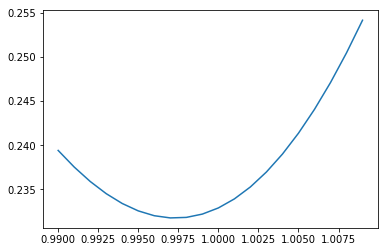

In [85]:
# whole correction
# 从0.99开始尝试跟新权重值，找到最优权重=
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    pre_revised = np.expm1(yhat*w)
    real_raw = np.expm1(label_hold['Sales'].values)
    error = rmspe(real_raw,pre_revised)
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [86]:
# correction by store
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(features_hold[features_hold['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [87]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(label_hold['Sales'].values), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.238269


## Preparing testing data
- 注意到 test 中 ’Id‘是多余的
- test 中 StateHoliday 的种类少了3类，在进行独热编码后，需要补全

In [88]:
len(test['Id'])

41088

In [89]:
len(store['Store'])

1115

## store 中增加了平均数据

In [90]:
avg_store = features[['Store','store.MEAN(train.Sales)','store.MEAN(train.Customers)']]

avg_store.head()

,Store,store.MEAN(train.Sales),store.MEAN(train.Customers)
0,1,8.446708,564.049936
1,2,8.453979,583.998724
2,3,8.795941,750.077022
3,4,9.154714,1321.752551
4,5,8.369616,537.340180


In [91]:
len(avg_store['Store'].unique())

1115

In [92]:
avg_store.drop_duplicates(inplace = True)

In [93]:
len(avg_store['Store'])

1115

In [94]:
len(store['Store'])

1115

In [95]:
#为什么上面 store 变位8万多行了？

store = pd.merge(store,avg_store,on ='Store',how ='left')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,store.MEAN(train.Sales),store.MEAN(train.Customers)
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",8.453979,583.998724
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",8.795941,750.077022
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,9.154714,1321.752551
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,8.369616,537.340180


In [96]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,store.MEAN(train.Sales),store.MEAN(train.Customers)
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5390.358744,4.930942,1370.939013,0.512108,12.083408,1030.239462,8.755617,754.565433
std,322.01708,7657.973705,4.284924,935.467654,0.500078,15.542241,1006.038782,0.319416,353.389229
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.806316,240.183099
25%,279.50000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.539424,541.468688
50%,558.00000,2320.000000,4.000000,2006.000000,1.000000,1.000000,2009.000000,8.759969,678.667519
75%,836.50000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000,8.946239,866.203304
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,9.962375,3403.458599


### 添加根据 weekofday 计算的周X平均销售量

In [97]:
avgperday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6723 entries, 0 to 6722
Data columns (total 3 columns):
Store        6723 non-null int64
DayOfWeek    6723 non-null int64
AvgPerDay    6723 non-null float64
dtypes: float64(1), int64(2)
memory usage: 157.6 KB


In [98]:
# 合并avgperday
test_features = pd.merge(test,avgperday,on =['Store','DayOfWeek'],how ='left')
test_features.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday,AvgPerDay
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,35292.000000
mean,20544.500000,555.899533,3.979167,0.854361,0.395833,0.443487,8.748144
std,11861.228267,320.274496,2.015481,0.352748,0.489035,0.496802,0.334587
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,7.190656
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000,8.537019
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000,8.751702
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000,8.955271
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,10.249988


In [99]:
# 这里出错了
test_features.head()

#pd.concat([test_features, df4], axis=1, join_axes=[df1.index])

test_features = pd.merge(test_features,store,on = 'Store',how ='left')
test_features.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday,AvgPerDay,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,store.MEAN(train.Sales),store.MEAN(train.Customers)
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,35292.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854361,0.395833,0.443487,8.748144,5076.693925,4.429907,1264.787383,0.580607,14.182243,1168.078271,8.748330,734.854654
std,11861.228267,320.274496,2.015481,0.352748,0.489035,0.496802,0.334587,7221.221850,4.214484,969.984740,0.493466,16.177932,992.765386,0.305042,352.537211
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,7.190656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.841599,240.183099
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000,8.537019,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.538039,525.565968
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000,8.751702,2410.000000,4.000000,2005.000000,1.000000,9.000000,2010.000000,8.743527,658.733141
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000,8.955271,6435.000000,9.000000,2011.000000,1.000000,31.000000,2012.000000,8.930662,835.649872
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,10.249988,75860.000000,12.000000,2015.000000,1.000000,49.000000,2015.000000,9.922527,3403.458599


In [100]:
list(test_features)

['Id',
 'Store',
 'DayOfWeek',
 'Date',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'AvgPerDay',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'store.MEAN(train.Sales)',
 'store.MEAN(train.Customers)']

In [101]:
# test_features.drop({'Id','Date'},
#               inplace = True, axis =1)
test_features.drop({'Id'},
               inplace = True, axis =1)

### date 分离年/月/日

In [102]:
#处理 test 中的日期
test_features.Date = pd.to_datetime(test_features.Date)#将日期数据转换为时间类型
test_features['YEAR(Date)'] = test_features.Date.map(lambda x:x.year)
test_features['MONTH(Date)'] = test_features.Date.map(lambda x:x.month)
test_features['DAY(Date)'] = test_features.Date.map(lambda x:x.day)

In [103]:
test_features.drop({'Date'},
               inplace = True, axis =1)

## 增加竞争者/促销时间

In [105]:
test_features['CompetitionExistMonth'] = 12 * (test_features['YEAR(Date)'] - test_features['CompetitionOpenSinceYear']) + (features['MONTH(Date)']-features['store.CompetitionOpenSinceMonth'])
    
#不存在竞争的，对应竞争存在月份当然置于0
test_features.loc[test_features['CompetitionOpenSinceYear'] == 0, 'CompetitionExistMonth'] =0

In [106]:
test_features['Promo2ExistMonth'] = 12 * (test_features['YEAR(Date)']-test_features['Promo2SinceYear']) +\
(test_features['MONTH(Date)']-test_features['Promo2SinceWeek']/4)
    
#不存在竞争的，对应竞争存在月份当然置于0
test_features.loc[test_features['Promo2SinceYear'] == 0, 'Promo2ExistMonth'] =0

In [107]:
test_features = pd.get_dummies(test_features,
                         prefix=['StateHoliday', 'store.StoreType', 'store.Assortment','store.PromoInterval'], 
                         drop_first=True)

In [108]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 28 columns):
Store                                   41088 non-null int64
DayOfWeek                               41088 non-null int64
Open                                    41088 non-null float64
Promo                                   41088 non-null int64
SchoolHoliday                           41088 non-null int64
AvgPerDay                               35292 non-null float64
CompetitionDistance                     41088 non-null float64
CompetitionOpenSinceMonth               41088 non-null float64
CompetitionOpenSinceYear                41088 non-null float64
Promo2                                  41088 non-null int64
Promo2SinceWeek                         41088 non-null float64
Promo2SinceYear                         41088 non-null float64
store.MEAN(train.Sales)                 41088 non-null float64
store.MEAN(train.Customers)             41088 non-null float64
YEAR(Date)         

In [109]:
# Get missing columns in the test data
missing_cols = {'StateHoliday_b','StateHoliday_c'}

In [110]:
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_features[c] = 0
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 30 columns):
Store                                   41088 non-null int64
DayOfWeek                               41088 non-null int64
Open                                    41088 non-null float64
Promo                                   41088 non-null int64
SchoolHoliday                           41088 non-null int64
AvgPerDay                               35292 non-null float64
CompetitionDistance                     41088 non-null float64
CompetitionOpenSinceMonth               41088 non-null float64
CompetitionOpenSinceYear                41088 non-null float64
Promo2                                  41088 non-null int64
Promo2SinceWeek                         41088 non-null float64
Promo2SinceYear                         41088 non-null float64
store.MEAN(train.Sales)                 41088 non-null float64
store.MEAN(train.Customers)             41088 non-null float64
YEAR(Date)         

In [111]:
test_features =test_features.rename(columns={'CompetitionDistance':'store.CompetitionDistance',
                                              'CompetitionOpenSinceMonth':'store.CompetitionOpenSinceMonth',
                                              'CompetitionOpenSinceYear':'store.CompetitionOpenSinceYear',
                                              'Promo2':'store.Promo2',
                                              'Promo2SinceWeek':'store.Promo2SinceWeek',
                                              'Promo2SinceYear':'store.Promo2SinceYear'})
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 30 columns):
Store                                   41088 non-null int64
DayOfWeek                               41088 non-null int64
Open                                    41088 non-null float64
Promo                                   41088 non-null int64
SchoolHoliday                           41088 non-null int64
AvgPerDay                               35292 non-null float64
store.CompetitionDistance               41088 non-null float64
store.CompetitionOpenSinceMonth         41088 non-null float64
store.CompetitionOpenSinceYear          41088 non-null float64
store.Promo2                            41088 non-null int64
store.Promo2SinceWeek                   41088 non-null float64
store.Promo2SinceYear                   41088 non-null float64
store.MEAN(train.Sales)                 41088 non-null float64
store.MEAN(train.Customers)             41088 non-null float64
YEAR(Date)         

In [112]:
# Ensure the order of column in the test set is in the same order than in train set
test_features = test_features[features.columns]



In [113]:
# check if the test feature number is 25 or not
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 30 columns):
Store                                   41088 non-null int64
DayOfWeek                               41088 non-null int64
Open                                    41088 non-null float64
Promo                                   41088 non-null int64
SchoolHoliday                           41088 non-null int64
DAY(Date)                               41088 non-null int64
YEAR(Date)                              41088 non-null int64
MONTH(Date)                             41088 non-null int64
store.CompetitionDistance               41088 non-null float64
store.CompetitionOpenSinceMonth         41088 non-null float64
store.CompetitionOpenSinceYear          41088 non-null float64
store.Promo2SinceWeek                   41088 non-null float64
store.Promo2SinceYear                   41088 non-null float64
store.Promo2                            41088 non-null int64
store.MEAN(train.Sales)  

In [114]:
test_features.isnull().any()

Store                                   False
DayOfWeek                               False
Open                                    False
Promo                                   False
SchoolHoliday                           False
DAY(Date)                               False
YEAR(Date)                              False
MONTH(Date)                             False
store.CompetitionDistance               False
store.CompetitionOpenSinceMonth         False
store.CompetitionOpenSinceYear          False
store.Promo2SinceWeek                   False
store.Promo2SinceYear                   False
store.Promo2                            False
store.MEAN(train.Sales)                 False
store.MEAN(train.Customers)             False
AvgPerDay                                True
CompetitionExistMonth                   False
Promo2ExistMonth                        False
StateHoliday_a                          False
StateHoliday_b                          False
StateHoliday_c                    

In [115]:
len(test_features['AvgPerDay'])

41088

In [116]:
test_features.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,DAY(Date),YEAR(Date),MONTH(Date),store.CompetitionDistance,store.CompetitionOpenSinceMonth,...,StateHoliday_b,StateHoliday_c,store.StoreType_b,store.StoreType_c,store.StoreType_d,store.Assortment_b,store.Assortment_c,"store.PromoInterval_Feb,May,Aug,Nov","store.PromoInterval_Jan,Apr,Jul,Oct","store.PromoInterval_Mar,Jun,Sept,Dec"
0,1,4,1.0,1,0,17,2015,9,1270.0,9.0,...,0,0,0,1,0,0,0,0,0,0
1,3,4,1.0,1,0,17,2015,9,14130.0,12.0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,1.0,1,0,17,2015,9,24000.0,4.0,...,0,0,0,0,0,0,1,0,0,0
3,8,4,1.0,1,0,17,2015,9,7520.0,10.0,...,0,0,0,0,0,0,0,0,0,0
4,9,4,1.0,1,0,17,2015,9,2030.0,8.0,...,0,0,0,0,0,0,1,0,0,0


### 注意到 AverPerDay 还处在空缺值

In [117]:
test_features['AvgPerDay']


test_features.isnull().sum(axis = 0)

Store                                      0
DayOfWeek                                  0
Open                                       0
Promo                                      0
SchoolHoliday                              0
DAY(Date)                                  0
YEAR(Date)                                 0
MONTH(Date)                                0
store.CompetitionDistance                  0
store.CompetitionOpenSinceMonth            0
store.CompetitionOpenSinceYear             0
store.Promo2SinceWeek                      0
store.Promo2SinceYear                      0
store.Promo2                               0
store.MEAN(train.Sales)                    0
store.MEAN(train.Customers)                0
AvgPerDay                               5796
CompetitionExistMonth                      0
Promo2ExistMonth                           0
StateHoliday_a                             0
StateHoliday_b                             0
StateHoliday_c                             0
store.Stor

In [118]:
#df[pd.isnull(df).any(axis=1)]
test_features[pd.isnull(test_features).any(axis=1)]


,Store,DayOfWeek,Open,Promo,SchoolHoliday,DAY(Date),YEAR(Date),MONTH(Date),store.CompetitionDistance,store.CompetitionOpenSinceMonth,...,StateHoliday_b,StateHoliday_c,store.StoreType_b,store.StoreType_c,store.StoreType_d,store.Assortment_b,store.Assortment_c,"store.PromoInterval_Feb,May,Aug,Nov","store.PromoInterval_Jan,Apr,Jul,Oct","store.PromoInterval_Mar,Jun,Sept,Dec"
3424,1,7,0.0,0,0,13,2015,9,1270.0,9.0,...,0,0,0,1,0,0,0,0,0,0
3425,3,7,0.0,0,0,13,2015,9,14130.0,12.0,...,0,0,0,0,0,0,0,0,1,0
3426,7,7,0.0,0,0,13,2015,9,24000.0,4.0,...,0,0,0,0,0,0,1,0,0,0
3427,8,7,0.0,0,0,13,2015,9,7520.0,10.0,...,0,0,0,0,0,0,0,0,0,0
3428,9,7,0.0,0,0,13,2015,9,2030.0,8.0,...,0,0,0,0,0,0,1,0,0,0
3429,10,7,0.0,0,0,13,2015,9,3160.0,9.0,...,0,0,0,0,0,0,0,0,0,0
3430,11,7,0.0,0,0,13,2015,9,960.0,11.0,...,0,0,0,0,0,0,1,0,1,0
3431,12,7,0.0,0,0,13,2015,9,1070.0,0.0,...,0,0,0,0,0,0,1,0,1,0
3432,13,7,0.0,0,0,13,2015,9,310.0,0.0,...,0,0,0,0,1,0,0,1,0,0
3433,14,7,0.0,0,0,13,2015,9,1300.0,3.0,...,0,0,0,0,0,0,0,0,1,0


## 很奇怪全部都是 星期天的数据处在缺失

In [119]:
# 用0填充，这里值得再考虑
#test_features.fillna(0,inplace = True)

#采用平均值来填充NaN
test_features.fillna(avgperday['AvgPerDay'].mean(),inplace = True)

## Testing on the final gradient descent boost model

In [120]:
# # make predictions on the testing data
# test_sales = model.predict(test_features)
print("Make predictions on the test set")
dtest = xgb.DMatrix(test_features)
test_sales = gbm.predict(dtest)

Make predictions on the test set


In [121]:
test_sales

array([8.424688, 8.862026, 9.11521 , ..., 8.604646, 9.838676, 8.717923],
      dtype=float32)

In [122]:
# output test results to csv file
#采用平均值填充 avgperday 的空值
df = pd.DataFrame({"Id":range(1,len(test_sales) + 1),'Sales':np.expm1(test_sales)})
df.to_csv('xgboost_ft_final.csv',index = False)

### 对比其他参数模型结果

- 增加 subsample 确实有提高分数到 private= 0.12926,public =0.11688.可能因为本身构造的 features 数量就不多

- 减小 eta 也确实提高分数到 private= 0.12824,public =0.12120

In [146]:
test_sales1 = gbm1.predict(dtest)
df = pd.DataFrame({"Id":range(1,len(test_sales1) + 1),'Sales':np.expm1(test_sales1)})
df.to_csv('xgboost_ft_final1.csv',index = False)

In [148]:
test_sales2 = gbm2.predict(dtest)
df = pd.DataFrame({"Id":range(1,len(test_sales2) + 1),'Sales':np.expm1(test_sales2)})
df.to_csv('xgboost_ft_final2.csv',index = False)

In [147]:
test_sales3 = gbm3.predict(dtest)
df = pd.DataFrame({"Id":range(1,len(test_sales3) + 1),'Sales':np.expm1(test_sales3)})
df.to_csv('xgboost_ft_final3.csv',index = False)

###  发现 gbm2 与 gbm3 的 private/public 分数都较好 blending 融合模型

In [151]:
blending = (test_sales2 + test_sales3)/2
df = pd.DataFrame({"Id":range(1,len(test_sales3) + 1),'Sales':np.expm1(blending)})
df.to_csv('xgboost_ft_final_blending.csv',index = False)

In [152]:
blending_corrected = (test_sales2 + test_sales3)*0.997/2
df = pd.DataFrame({"Id":range(1,len(test_sales3) + 1),'Sales':np.expm1(blending_corrected)})
df.to_csv('xgboost_ft_final_blending_corrected.csv',index = False)

## The final score on  leaderboard

### best Public Score 0.11688
### best Private Score 0.12794

- 基本达到要求 private score 0.1175
- 但是对这个结果真的很意外
- 而且对 test 中的(dayofweek,avgsales)无论采用0或者均值填充，得分一模一样



## 添加修正系数后的结果

## The final score on  leaderboard

### Public Score 0.11899
### Private Score 0.13842

- 与没有添加修正系数相比，结果相差无几
- 因为修正系数也是通过验证集来得到的，测试集上不适用完全有可能


In [123]:
#固定修正系数
df = pd.DataFrame({"Id":range(1,len(test_sales) + 1),'Sales':np.expm1(test_sales*0.997)})
df.to_csv('xgboost_ft_final_corrected.csv',index = False)

In [ ]:
#固定修正系数
df = pd.DataFrame({"Id":range(1,len(test_sales) + 1),'Sales':np.expm1(test_sales*1.003)})
df.to_csv('xgboost_ft_final_corrected_h.csv',index = False)

### 研究 feature importance

In [124]:
# create feature map
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feature in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feature))
    outfile.close()

create feature map to get feature importance


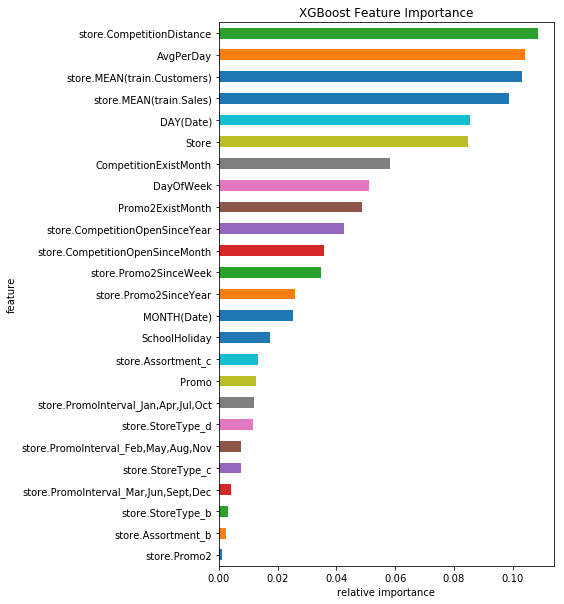

In [125]:
# XGB feature importances
print('create feature map to get feature importance')
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_gboost_ft_fillavg.png', bbox_inches='tight', pad_inches=1)

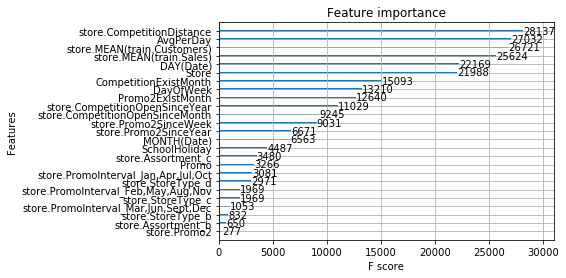

In [126]:
xgb.plot_importance(gbm,importance_type ='weight')

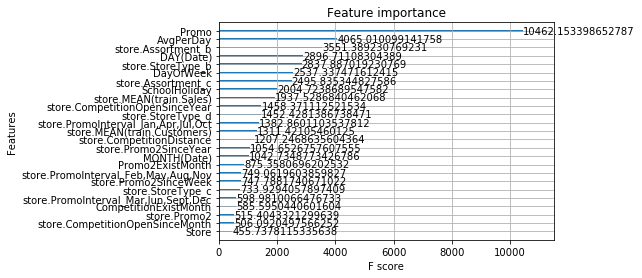

In [127]:
xgb.plot_importance(gbm,importance_type ='cover')

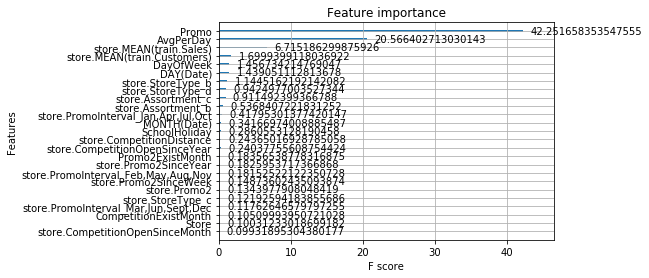

In [128]:
xgb.plot_importance(gbm,importance_type ='gain')

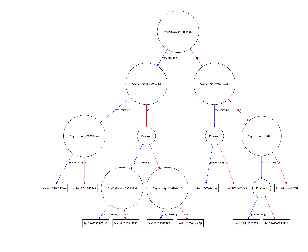

In [129]:
#import graphviz
from xgboost import plot_tree
plot_tree(gbm)
plt.show()

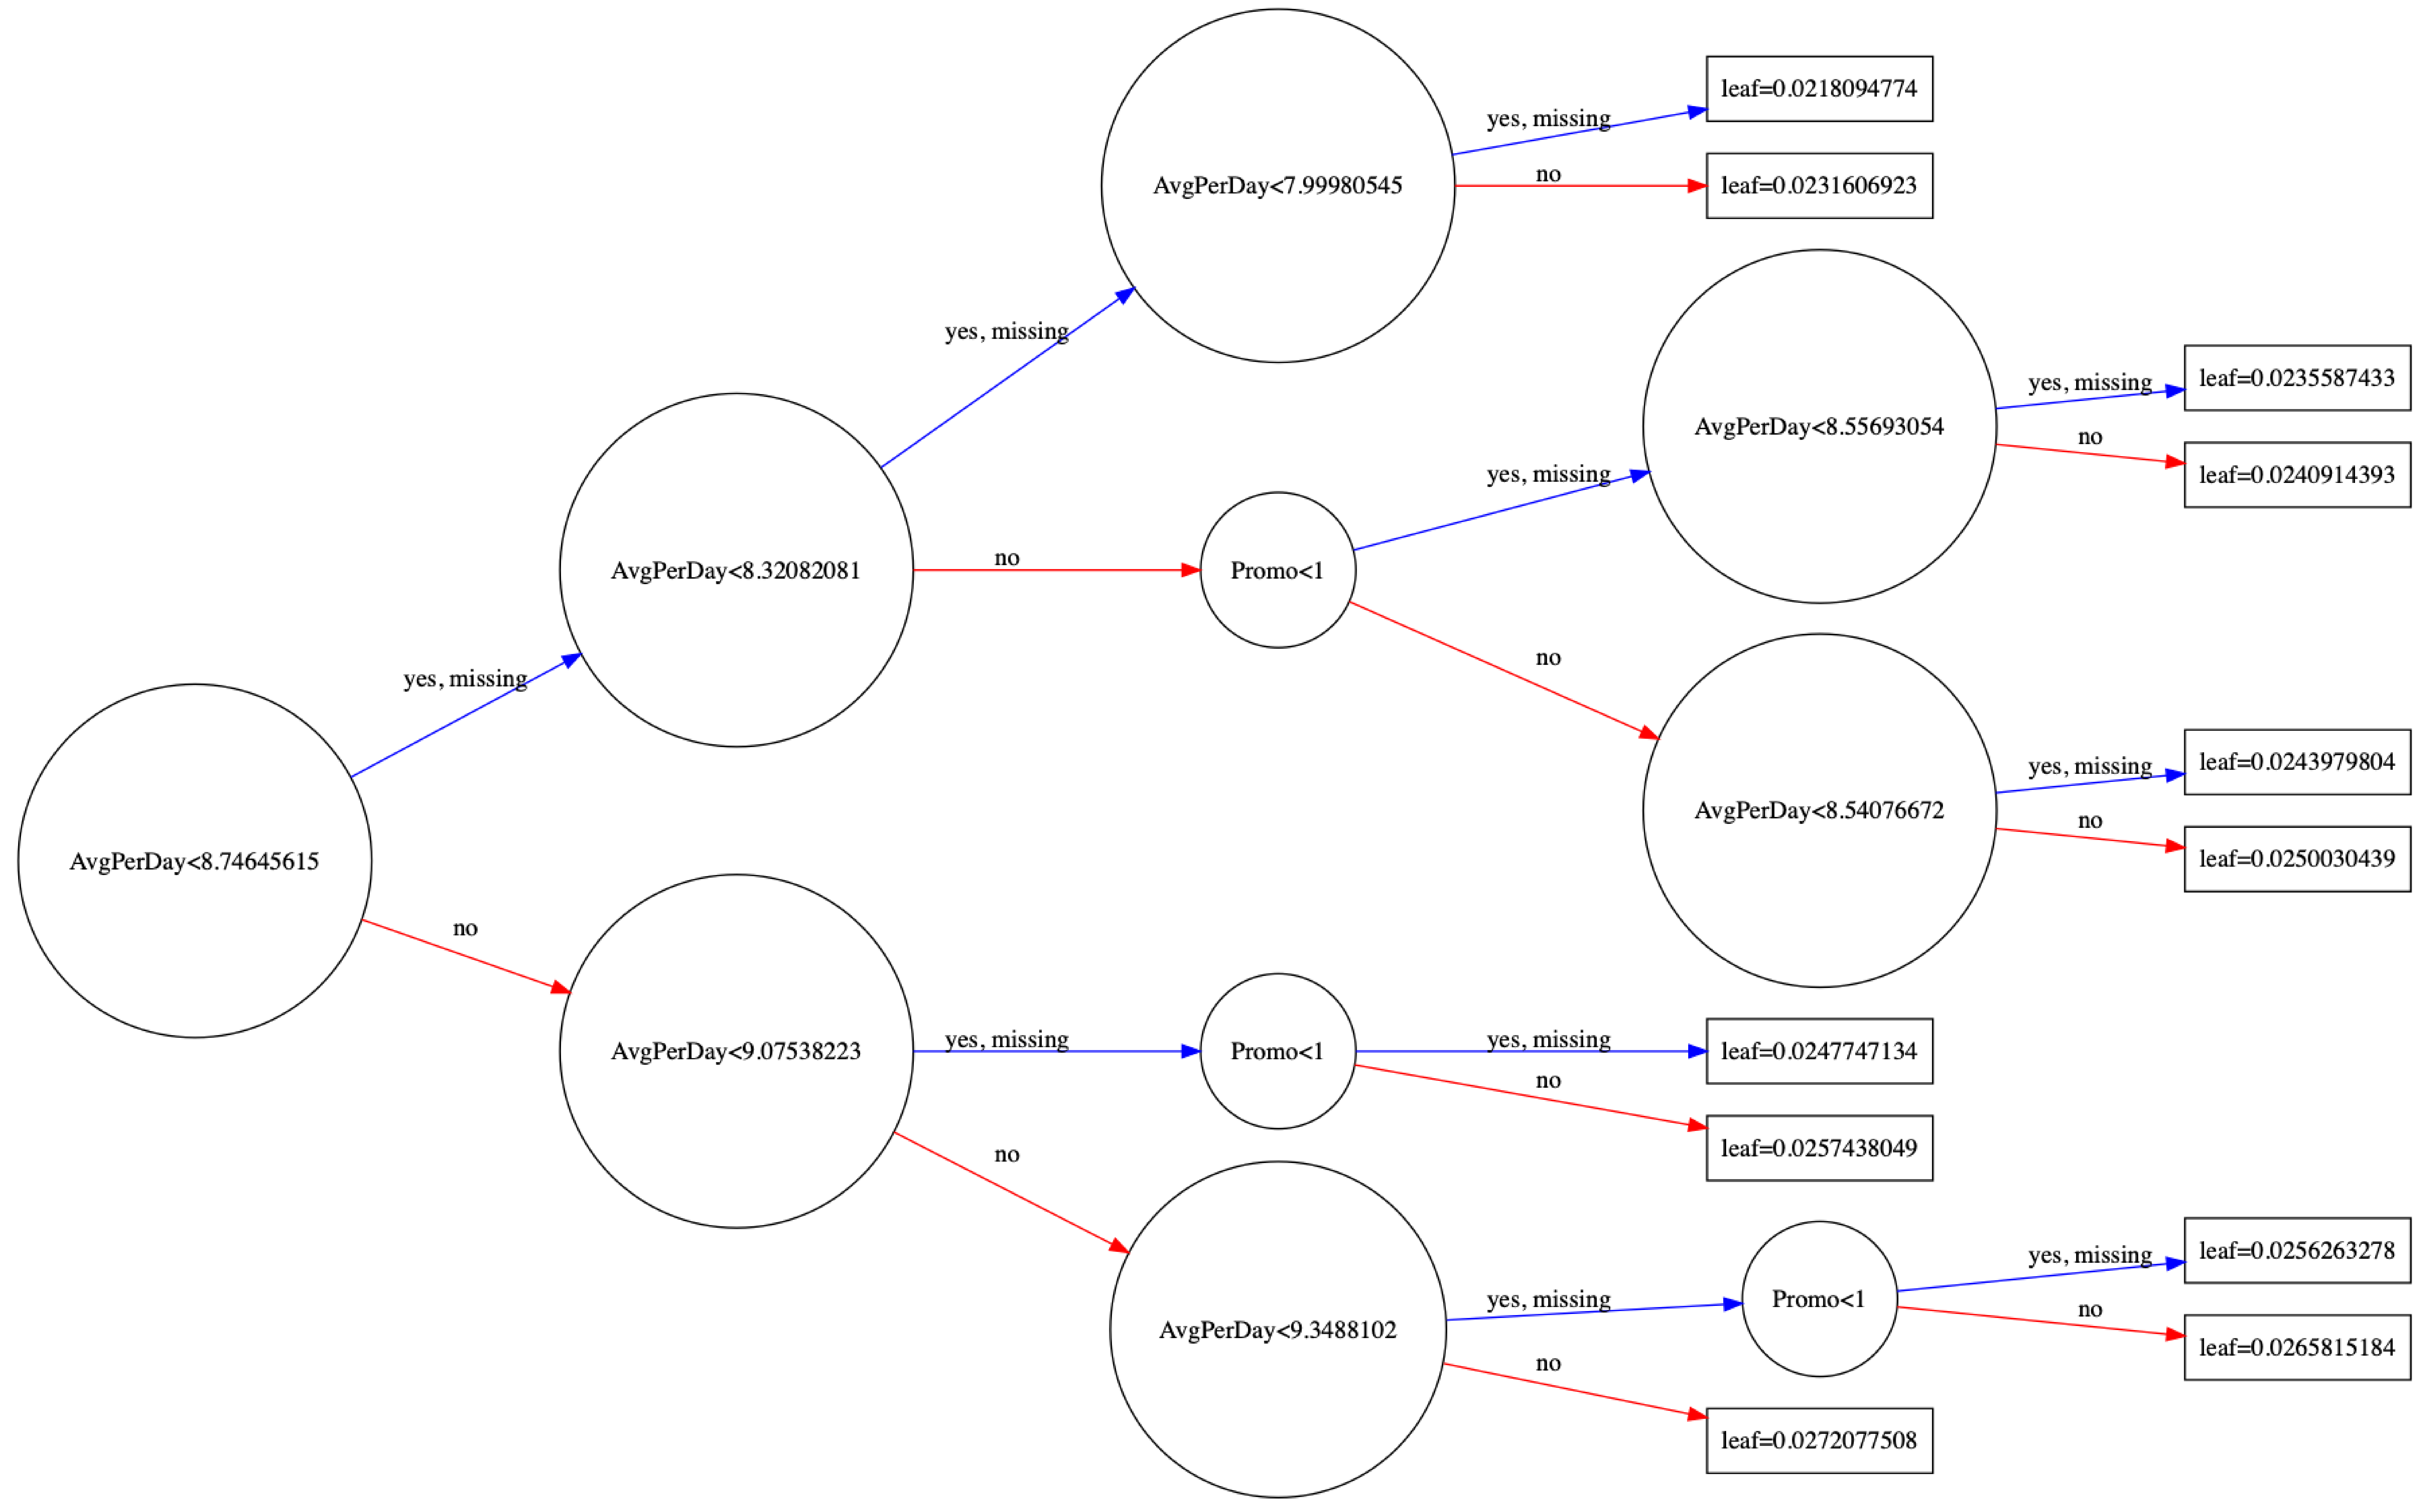

In [130]:
plot_tree(gbm, num_trees=0, rankdir='LR')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree-horizontal.png')

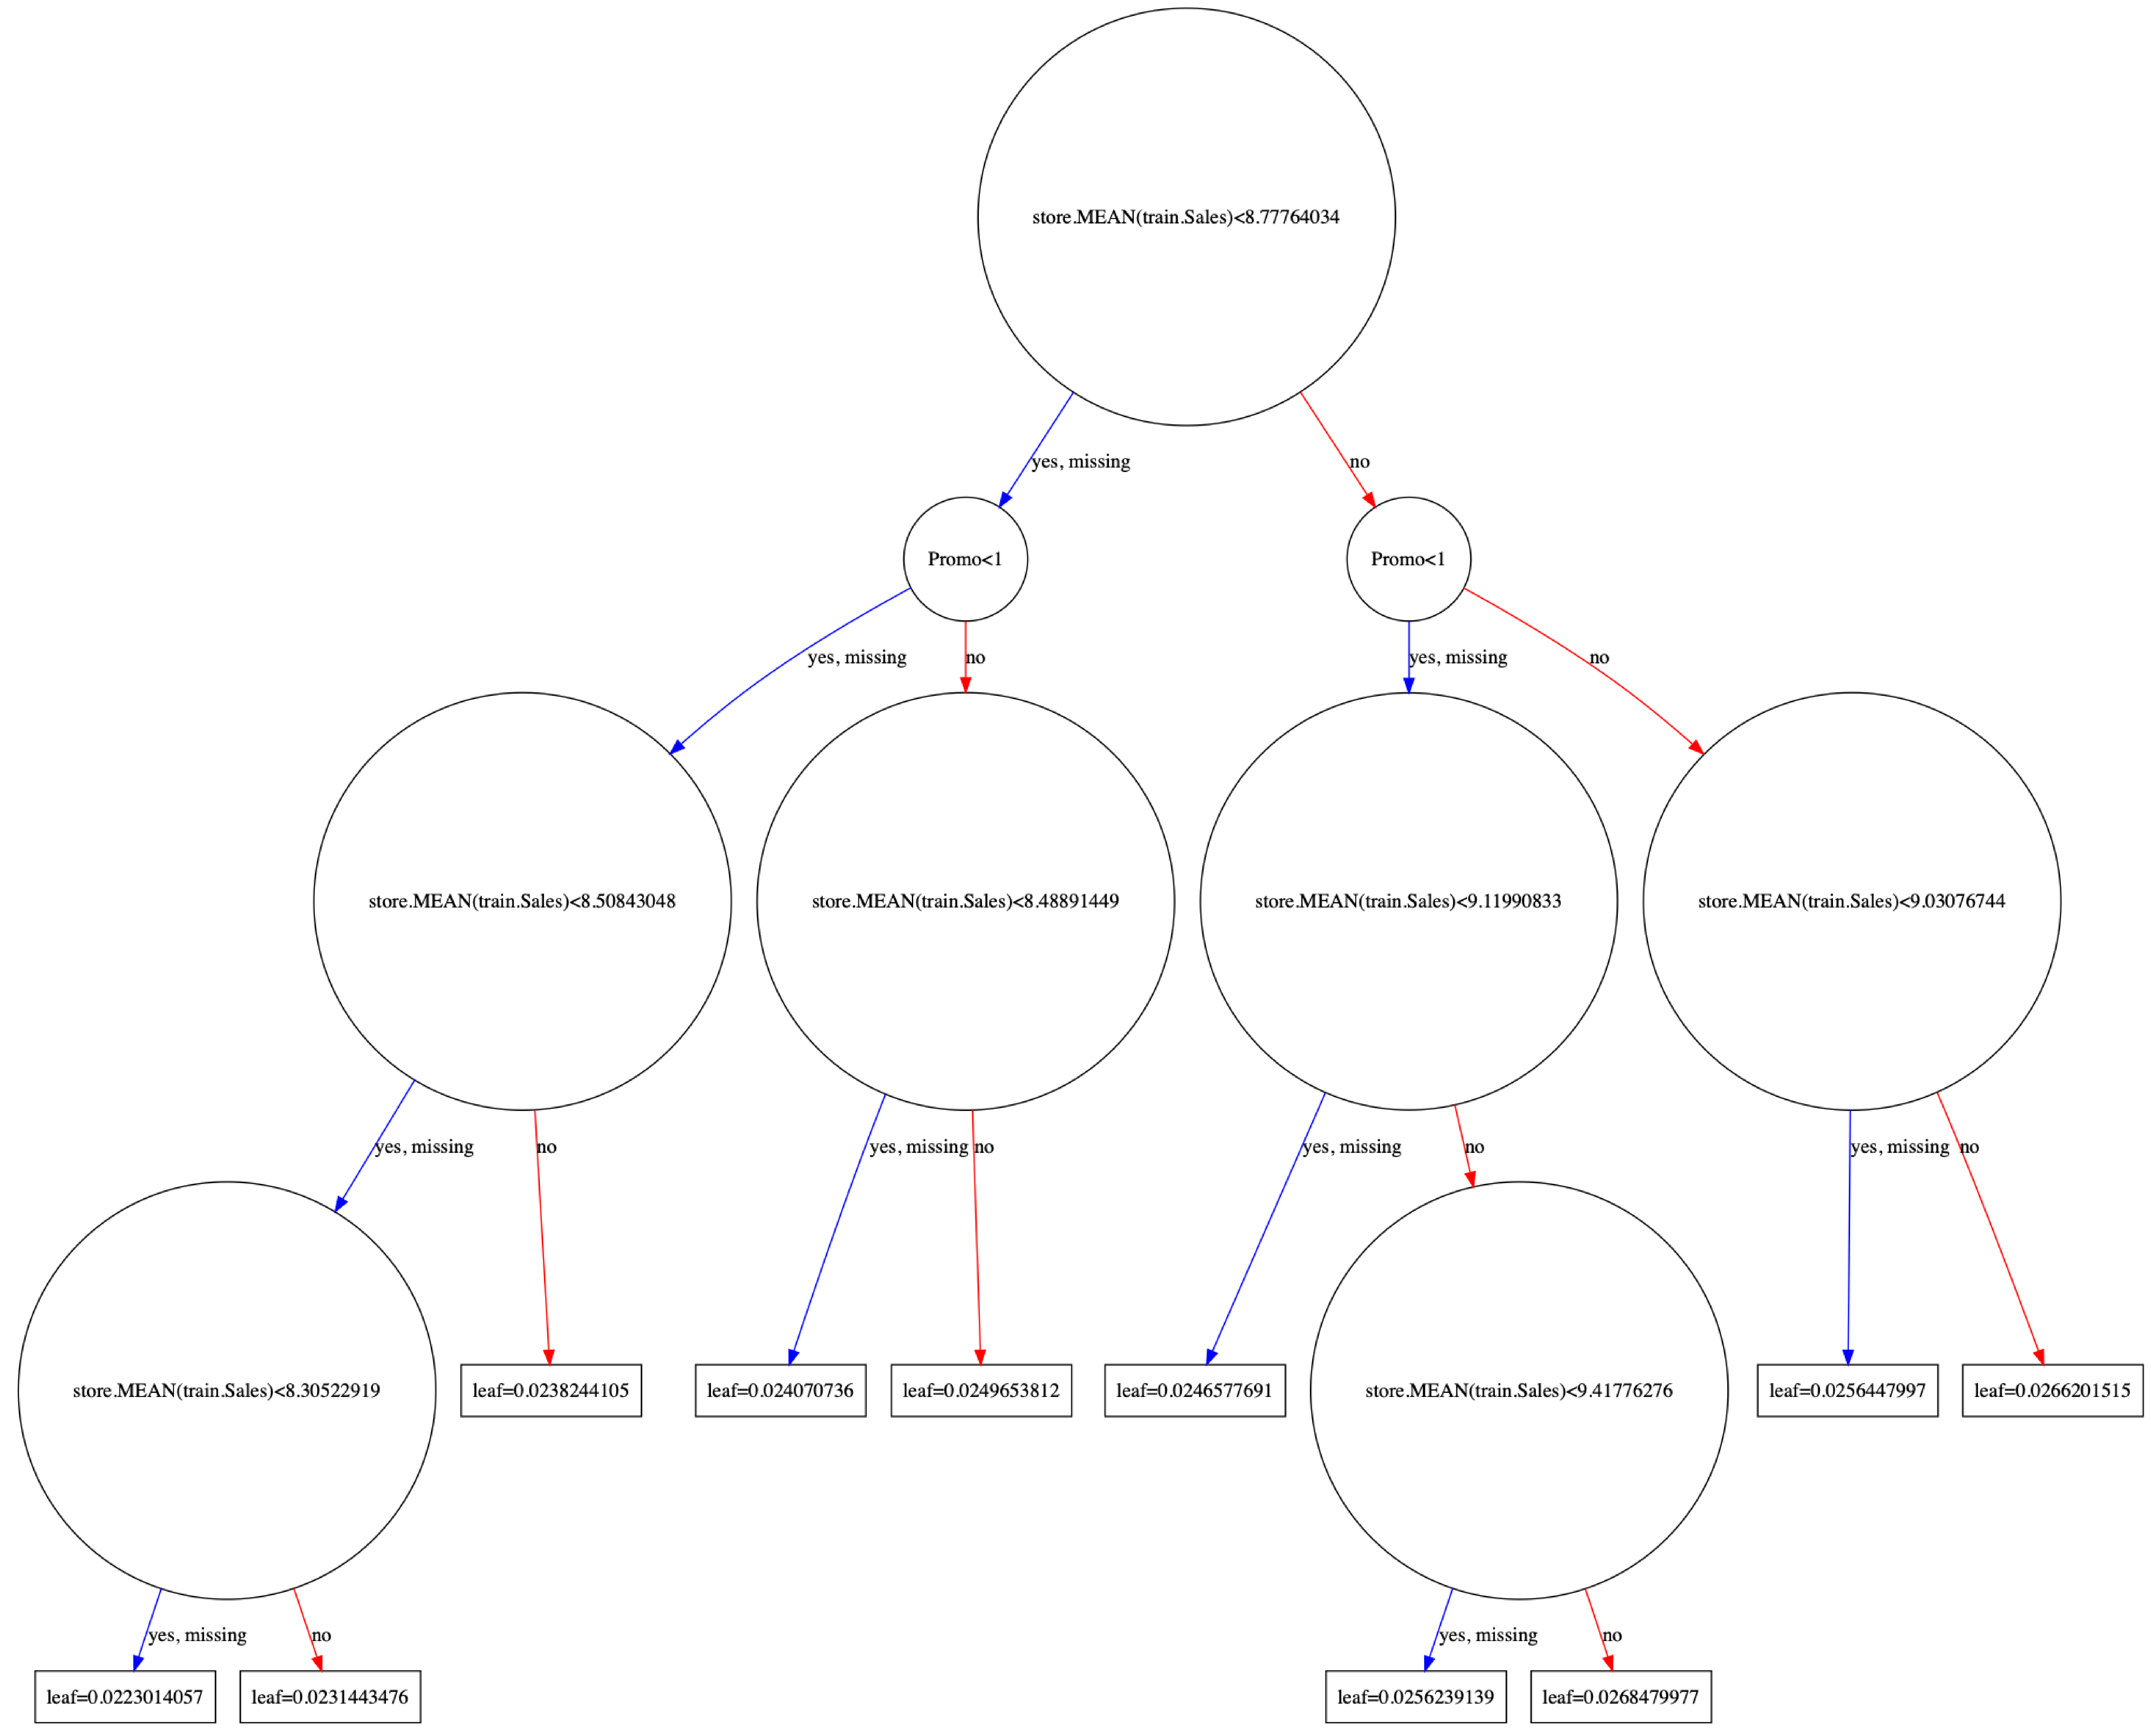

In [131]:
xgb.plot_tree(gbm, num_trees=2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

## 采用 SHAP 来准确评估 feature importance

- xgboost 的 plot_importance() 不同方式下，得到的结果不尽相同

- 采用具有 consistance 特点的 feature importance 评价库 SHAP

- 参考：https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

/Users/limao/miniconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


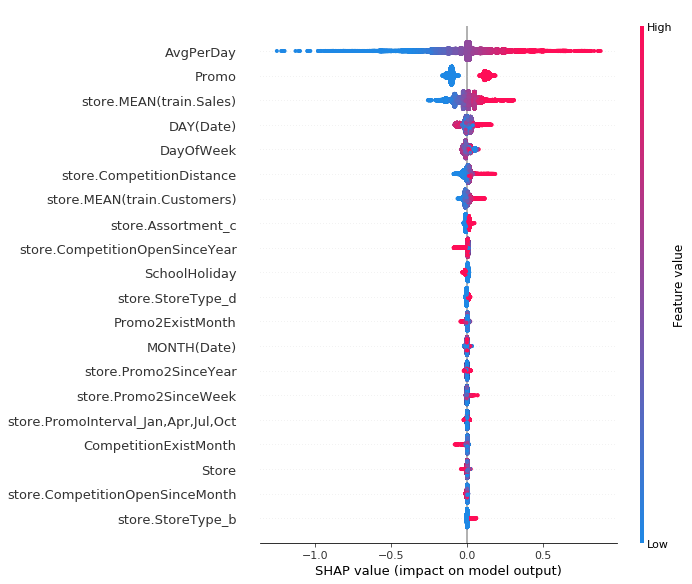

In [132]:
import shap
shap_values = shap.TreeExplainer(gbm).shap_values(test_features)
shap.summary_plot(shap_values, test_features)

## SHAP Dependence Plots
- summary plot 给出的是 general view 
- SHAP dependence plot 给出的是模型输出跟随每个 feature 值得变化而发生的改变

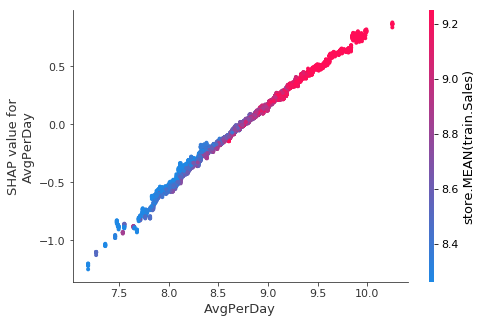

In [133]:
# 我们研究每个 DayOfWeek 平均销量对输出结果的影响
shap.dependence_plot("AvgPerDay", shap_values, test_features)

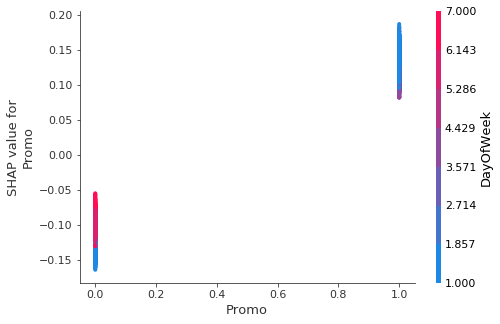

In [134]:
shap.dependence_plot("Promo", shap_values, test_features)

## SHAP Interaction Value Summary Plot

In [135]:
shap_interaction_values = shap.TreeExplainer(gbm).shap_interaction_values(test_features.iloc[:2000,:])

KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_interaction_values, test_features.iloc[:2000,:])

## 非常疑惑

- 此模型没有增加“时间窗” features，甚至 day/month/year 都没有保留，表现反而很好
- 此模型 eval-rmspe:0.233946 和 下面笔记本中的 eval-rmspe几乎相同，后者增加了时间窗features，反而表现很差0.58
- https://github.com/lidatou1991/udacity_final_rossmann/blob/master/xgbm-add-feature.ipynb
- 接下来我想尝试在本notebook上增加时间窗 features，对比结果